# DFL benchmark - training
This is a simple benchmark script for DFL.  
It classifies each frame image in the video into 4 classes（'background','challenge','play','throwin'） 
It does not use temporal information, so it may not be competitive on its own for this competition, but it could be used as a feature extractor for more advanced models.

In [1]:
!nvidia-smi

Sun Sep 18 13:35:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   53C    P8    37W / 350W |    598MiB / 24576MiB |     27%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython.display import Video
import cv2

# setting

In [3]:
DEBUG = False

In [4]:
class CFG:
    train_csv = "/workdir/work/input/train.csv"
    video_dir = "/workdir/work/input/train"

    result_dir = f"/workdir/work/output/train_images_inferbase/"
    output_train_csv = "/workdir/work/output/train_images_inferbase.csv"

    # optical flow settings
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100,
                        qualityLevel = 0.3,
                        minDistance = 7,
                        blockSize = 7 )

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                    maxLevel = 2,
                    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    CAL_FLOW_TIME = 0.5
    skip_time_interval = 0.3
    crop_range = 800
    area_thr = 0.2
    IMG_SIZE = 456
    dis_thr = 5.0

# optical flow functions

In [5]:
def get_maxflow_area(x, y, width, height, crop_range=CFG.crop_range):
    crop_x_min = int(x) - (crop_range/2)
    crop_x_max = int(x) + (crop_range/2)
    crop_x_min = max(0, crop_x_min)
    crop_x_max = min(width, crop_x_max)

    crop_y_min = int(y) - (crop_range/2)
    crop_y_max = int(y) + (crop_range/2)
    crop_y_min = max(0, crop_y_min)
    crop_y_max = min(height, crop_y_max)

    return int(crop_x_min), int(crop_x_max), int(crop_y_min), int(crop_y_max)

In [6]:
def get_green_area(img):
    # HSV
    img_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # creat green mask (H value for green is from 100/360*179 until 180/360*179) in OpenCV
    lower_green = np.array([100 / 360 * 179, 0, 0])
    upper_green = np.array([180 / 360 * 179, 255, 255])
    green_mask = cv2.inRange(img_HSV, lower_green, upper_green)

    # crop green area
    img_green_masked = cv2.bitwise_and(img, img, mask=green_mask)
    img_green_masked = cv2.cvtColor(img_green_masked, cv2.COLOR_BGR2GRAY)

    # Find contours
    contours, hierarchy = cv2.findContours(img_green_masked, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return int(img.shape[1]*0.5), int(img.shape[0]*0.5), img.shape[1], img.shape[0]
    # Find the contour with the maximum area.
    c = max(contours, key=cv2.contourArea)

    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(c)

    return x, y, w, h

In [7]:
def crop_maxflow_area(cap_, fps_, frame_num_):
    """色相が緑っぽいエリアをフィールドとしてクロップして、optical flowを計算。1secでflowが最も大きい点を中心としてcropする。
    
    """
    cap_.set(cv2.CAP_PROP_POS_FRAMES, frame_num_)
    successed, base_frame = cap_.read()
    if not successed:
        return [], -1, -1

    # optical flow line color
    line_color = [255, 100, 0]
    # base frameでフィールドの範囲を決める。1secで大きくカメラ方向が移動するときはだめかも
    x_field, y_field, w_field, h_field = get_green_area(base_frame)
    base_frame = base_frame[y_field:y_field+h_field, x_field:x_field+w_field, :]

    # Take first frame and find corners in it
    base_gray = cv2.cvtColor(base_frame, cv2.COLOR_BGR2GRAY)
    base_point = cv2.goodFeaturesToTrack(base_gray, mask = None, **CFG.feature_params)
    # Create a mask image for drawing purposes
    mask = np.zeros_like(base_frame)

    # draw the tracks
    max_distance = 0
    img_max_dist = base_frame

    # 1secで基準画像とのoptical flowが最も大きい点を残す
    for i in range(int(fps_*CFG.CAL_FLOW_TIME)):
        successed, relative_frame = cap_.read()
        if not successed:
            continue

        # base frameで決めたフィールドの範囲をcrop
        relative_frame = relative_frame[y_field : y_field+h_field, x_field : x_field+w_field, :]
        relative_gray = cv2.cvtColor(relative_frame, cv2.COLOR_BGR2GRAY)

        # calculate optical flow
        relative_point, st, err = cv2.calcOpticalFlowPyrLK(base_gray, relative_gray, base_point, None, **CFG.lk_params)

        # Select good points
        good_new = relative_point[st==1]
        good_old = base_point[st==1]

        x_max_distance = int(x_field + (w_field*0.5))
        y_max_distance = int(y_field + (h_field*0.5))
        distance_sum = 0
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            x_after, y_after = new.ravel()
            x_before, y_before = old.ravel()
            distance = np.sqrt( (x_after - x_before)**2 + (y_after - y_before)**2 )
            distance_sum += distance
            # distanceが大きい、かつ、検出点が画像の外側area_thr%にないときに移動距離が最大と判定する
            if distance > max_distance and (w_field*CFG.area_thr < x_after < w_field*(1.0 -CFG.area_thr)) and (h_field*CFG.area_thr < y_after < y_field*(1.0 - CFG.area_thr)):
                max_distance = distance
                x_max_distance = x_after
                y_max_distance = y_after
                # 画像にoptical flow の線を追加する(本当はtop5だけ描くとかの方がいいかも？)
                # mask = cv2.line(mask, (int(x_after),int(y_after)), (int(x_before), int(y_before)), line_color, 2)
                img_max_dist = cv2.line(relative_frame, (int(x_after),int(y_after)), (int(x_before), int(y_before)), line_color, 2)
                # img_max_dist = cv2.circle(img_max_dist, (int(x_after),int(y_after)), 5, line_color, -1)

    distance_mean = distance_sum / (i+1)
    # optical flowの最も大きい点を中心にクロップ(サイズが足りないときは横方向だけとか縦方向だけの場合もあり)
    x_min, x_max, y_min, y_max = get_maxflow_area(int(x_max_distance), int(y_max_distance), w_field, h_field)
    croped_flow_image = img_max_dist[y_min:y_max, x_min:x_max, :]
    croped_flow_image = cv2.resize(croped_flow_image, dsize=(CFG.IMG_SIZE, CFG.IMG_SIZE))

    return croped_flow_image, max_distance, distance_mean


# Load data

In [8]:
# save images around event in result dir
if not os.path.exists(CFG.result_dir):
    os.makedirs(CFG.result_dir)

In [9]:
df = pd.read_csv(CFG.train_csv)
df = df[["video_id", "time", "event"]]
display(df)
# video_ids = df["video_id"].unique()#全動画を対象にする場合はこれ
video_ids = ["1606b0e6_0", "1606b0e6_1", "cfbe2e94_0", "cfbe2e94_1"]
if DEBUG:
    video_ids = ["1606b0e6_0", "cfbe2e94_0"]
print(video_ids)

,video_id,time,event
0,1606b0e6_0,200.265822,start
1,1606b0e6_0,201.150000,challenge
2,1606b0e6_0,202.765822,end
3,1606b0e6_0,210.124111,start
4,1606b0e6_0,210.870000,challenge
...,...,...,...
11213,ecf251d4_0,3056.587000,challenge
11214,ecf251d4_0,3058.072895,end
11215,ecf251d4_0,3068.280519,start
11216,ecf251d4_0,3069.547000,throwin


['1606b0e6_0', '1606b0e6_1', 'cfbe2e94_0', 'cfbe2e94_1']


In [10]:
def make_saved_event_df(save_event_df_, video_id_, frame_, target_, distance_, distance_mean_):
    save_list = [video_id_, frame_, target_, distance_, distance_mean_]
    if len(save_event_df_) == 0:
        save_event_df_ = pd.DataFrame([save_list], columns=["video_id", "frame", "event", "distance", "distance_mean"])
    else:
        tmp_event_df_ = pd.DataFrame([save_list], columns=["video_id", "frame", "event", "distance", "distance_mean"])
        save_event_df_ = pd.concat([save_event_df_, tmp_event_df_])
    return save_event_df_

# Extract training images fucntion

In [11]:
from operator import ne


def extract_training_images(video_id):
    saved_image_df = pd.DataFrame()
    video_path = f"{CFG.video_dir}/{video_id}.mp4"
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    if not cap.isOpened():
        print(f"video {video_path} cannot be opened.")
        return
    
    df_video = df[df.video_id == video_id]
    if DEBUG:
        df_video = df_video.head(10)
    print(video_id)

    #crr_statu => background, play, challenge, throwin
    time_and_event = df_video[['time','event']].values
    if DEBUG:
        time_and_event = time_and_event[:3]
    idx = 0
    saved_frame_list = []
    save_event_df = pd.DataFrame()
    distance_mean_list = []
    to_csv_count = 1

    elapsed_time_sum = 0
    current_frame = 1
    current_time = int(current_frame/fps)

    next_event_time = time_and_event[0, 0]
    next_event = time_and_event[0, 1]
    target = next_event
    distance_mean = -1
    start_time = time.time()
    
    while True:
        print("\r" + f"start  frame:{int(current_frame)}/{int(total_frame)}, event:{next_event}, idx:{idx}, dis:{distance_mean}", end="")
        if (next_event_time <= current_time):
            idx += 1
            if len(time_and_event) > idx:
                next_event_time = time_and_event[idx, 0]
                next_event = time_and_event[idx, 1]
                if target == "start":
                    target = next_event
                continue
            else:
                print("\r" + f"break3 frame:{int(current_frame)}/{int(total_frame)}, event:{next_event}, idx:{idx}, dis:{distance_mean}", end="")
                break

        if (next_event == "start") or (current_frame in saved_frame_list):
            current_frame += 1
            current_time = current_frame/fps
            continue

        croped_flow_image, max_distance, distance_mean = crop_maxflow_area(cap, fps, current_frame)
        if max_distance == -1:
            print("\r" + f"break1 frame:{int(current_frame)}/{int(total_frame)}, event:{next_event}, idx:{idx}, dis:{distance_mean}", end="")
            break
        distance_mean_list.append([current_frame, distance_mean])
        
        if to_csv_count > 10000:
            distance_mean_df = pd.DataFrame(distance_mean_list, columns=["frame", "distance_mean"])
            distance_mean_df.to_csv(f"/workdir/work/output/{video_id}_distancemean_{to_csv_count}.csv", index=False)
            distance_mean_list = []
            to_csv_count += 1

        if distance_mean < 4:
            current_frame += int(CFG.skip_time_interval*fps)
            current_time = current_frame/fps
            continue
                       
        if next_event == 'start' or (current_frame in saved_frame_list):
            current_frame += 1
            # print("\r" + f"cont   frame:{int(current_frame)}/{int(total_frame)}, event:{next_event}, idx:{idx}, dis:{distance_mean}", end="")               
            # target = 'background'
            # out_file = f'{CFG.result_dir}/{video_id}_{current_frame:06}.jpg'
            # cv2.imwrite(out_file, croped_flow_image)
            # save_event_df = make_saved_event_df(save_event_df, video_id, current_frame, target, max_distance, distance_mean)
        elif next_event == 'end' and not (current_frame in saved_frame_list):
            # target = next_event
            out_file = f'{CFG.result_dir}/{video_id}_{current_frame:06}.jpg'
            cv2.imwrite(out_file, croped_flow_image)
            save_event_df = make_saved_event_df(save_event_df, video_id, current_frame, target, max_distance, distance_mean)
            current_frame += 1 
        else:
            target = next_event
            out_file = f'{CFG.result_dir}/{video_id}_{current_frame:06}.jpg'
            cv2.imwrite(out_file, croped_flow_image)
            save_event_df = make_saved_event_df(save_event_df, video_id, current_frame, target, max_distance, distance_mean)
            current_frame += 1
    
    elapsed_time = time.time() - start_time
    print("")
    print(f"  video {video_id} is finished. elapsed time={(elapsed_time/60):04f} min. saved image num={len(save_event_df)}.")
    distance_mean_df = pd.DataFrame(distance_mean_list, columns=["frame", "distance_mean"])
    distance_mean_df.to_csv(f"/workdir/work/output/{video_id}_distancemean_{to_csv_count}.csv", index=False)
    save_event_df["time"] = save_event_df["frame"]/fps
    return save_event_df

In [12]:
train_images_df = pd.DataFrame()
for video_id in video_ids:            
    video_event_df = extract_training_images(video_id)
    print(f"\t video {video_id} is finished.")
    if len(train_images_df) == 0:
        train_images_df = video_event_df
    else:
        train_images_df = pd.concat([train_images_df, video_event_df])

print('done')

1606b0e6_0
break3 frame:75419/85915, event:end, idx:1000, dis:2.1099849063061793321955
  video 1606b0e6_0 is finished. elapsed time=85.124992 min. saved image num=37995.
	 video 1606b0e6_0 is finished.
1606b0e6_1
break3 frame:84903/85138, event:end, idx:1249, dis:3.91302913054110222292981
  video 1606b0e6_1 is finished. elapsed time=105.857456 min. saved image num=45698.
	 video 1606b0e6_1 is finished.
cfbe2e94_0
break3 frame:80482/90500, event:end, idx:823, dis:3.8347580545310631063785
  video cfbe2e94_0 is finished. elapsed time=62.681469 min. saved image num=28618.
	 video cfbe2e94_0 is finished.
cfbe2e94_1
break3 frame:89402/89925, event:end, idx:763, dis:3.1712267781492893289334
  video cfbe2e94_1 is finished. elapsed time=59.882192 min. saved image num=27025.
	 video cfbe2e94_1 is finished.
done


In [13]:
train_images_df.to_csv(CFG.output_train_csv, index=False)
print("Completed.")

Completed.


In [14]:
len(train_images_df)

139336

In [15]:
train_images_df["event"].value_counts

<bound method IndexOpsMixin.value_counts of 0    challenge
0    challenge
0    challenge
0    challenge
0    challenge
       ...    
0      throwin
0      throwin
0      throwin
0      throwin
0      throwin
Name: event, Length: 139336, dtype: object>

In [16]:
train_images_df["event"].value_counts()

play         111229
challenge     15096
throwin       13011
Name: event, dtype: int64

In [17]:
train_images_df

,video_id,frame,event,distance,distance_mean,time
0,1606b0e6_0,5007,challenge,0.0,16.049134,200.28
0,1606b0e6_0,5008,challenge,0.0,15.109529,200.32
0,1606b0e6_0,5009,challenge,0.0,17.871048,200.36
0,1606b0e6_0,5010,challenge,0.0,18.790614,200.40
0,1606b0e6_0,5011,challenge,0.0,21.235978,200.44
...,...,...,...,...,...,...
0,cfbe2e94_1,89390,throwin,0.0,8.433969,3575.60
0,cfbe2e94_1,89391,throwin,0.0,9.094970,3575.64
0,cfbe2e94_1,89392,throwin,0.0,7.196483,3575.68
0,cfbe2e94_1,89393,throwin,0.0,6.319773,3575.72


<AxesSubplot:>

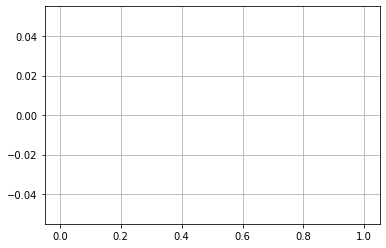

In [18]:
train_images_df[train_images_df["event"] == "background" ]["distance_mean"].hist(bins=50)

<AxesSubplot:>

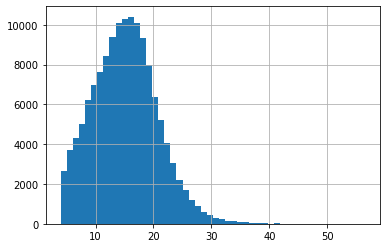

In [19]:
train_images_df[train_images_df["event"] != "background" ]["distance_mean"].hist(bins=50)